Algo steps
1. compute neigh
2. compute metrics (dist and angle)
3. pca
4. while criterion not met:
  - scale dimensions not needed
  - compute error on wanted dim and adjust values
 5. discard unwanted to obtain projection

parameters:
- k = num neigh
- lr (or whatever name): the step used to adjust wanted dimensions 

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from numba import njit

In [84]:
from ManifoldSculpting import ManifoldSculpting

In [85]:
def gen_roll(n):
    data = np.zeros((n,4))
    t = np.array([2+8*i/n for i in range(n)])
    data[:,0] = t*np.sin(t)
    data[:,2] = t*np.cos(t)
    data[:,1] = np.random.uniform(-6,6,n)
    data[:,3] = t
    return data

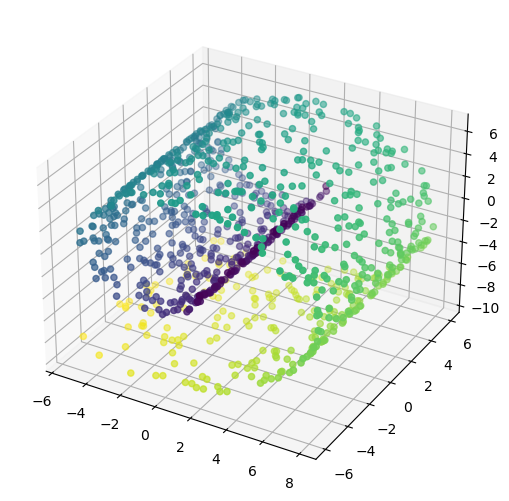

In [86]:
data = gen_roll(1000)
roll = data[:,:3]
phi = data[:,-1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],projection='3d')
ax.scatter3D(roll[:,0],roll[:,1],roll[:,2],c=phi)

In [87]:
from scipy.spatial.distance import cdist

In [88]:

def dum(data):
    d = cdist(data,data)
    return d

In [89]:
@njit
def dum(data):
    x2 = np.sum(data*data,axis = 1)
    data_t = data.T
    xx = data@data_t
    dist = np.sqrt(np.abs(x2.reshape((-1,1)) - 2*xx + x2))
    return dist

In [94]:
d = dum(roll)
dist = np.zeros((1000,5))
neigh = np.zeros((1000,5),dtype=np.int32)
for i in range(1000):
    neigh[i,:] = np.argsort(d[i])[1:6]
    dist[i,:] = d[i,neigh[i]]

In [95]:
tree = KDTree(roll)
dd,nn = tree.query(roll,6)
dd = dd[:,1:]
nn = nn[:,1:]

In [96]:
np.allclose(dist,dd)

True

In [71]:
%%timeit
_ = dum(roll)

3.94 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
%%timeit
_ = cdist(roll,roll)

3.99 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
np.allclose(dum(roll),cdist(roll,roll),atol=1e-6)

True

In [17]:
ms = ManifoldSculpting(k=12,n_dim=2,niter=30,sigma=0.95)
ms.fit(roll)

it:29, p:110

In [20]:
ms.pca_data[:,2]

array([-7.29922882e-01,  6.40222155e-01,  4.60618801e-01,  4.17049474e-01,
        1.21137031e+00,  3.35125045e-02, -3.37179572e-01,  5.58911717e-01,
        2.60152782e-01, -8.09059662e-01, -7.35918308e-01, -1.25804827e+00,
        8.16743552e-01, -4.27769585e-01,  1.17510710e+00, -4.96868704e-01,
        3.70922556e-01,  7.39313865e-01, -1.19022292e+00, -2.94388203e-01,
       -2.18294671e-01,  4.64701319e-01, -2.15819055e-01,  3.87187894e-01,
        6.79101309e-01, -1.43351934e-01,  5.11583148e-01,  8.42457892e-01,
       -3.25105919e-01,  3.06870160e-01,  1.26826868e-01,  8.65537714e-01,
       -1.34244396e-02, -3.40568841e-01, -1.21872549e+00,  4.56052046e-01,
       -9.95865252e-01,  7.82986260e-01,  3.51654577e-01, -1.27693333e+00,
        7.90617281e-01, -7.87928456e-01,  7.41302759e-01, -7.58558568e-01,
        1.11946723e+00,  3.64970731e-01, -8.85131427e-01,  1.14364271e+00,
        5.51843128e-01, -6.54602938e-01,  8.31561392e-01, -1.07817676e+00,
       -1.10410160e+00,  

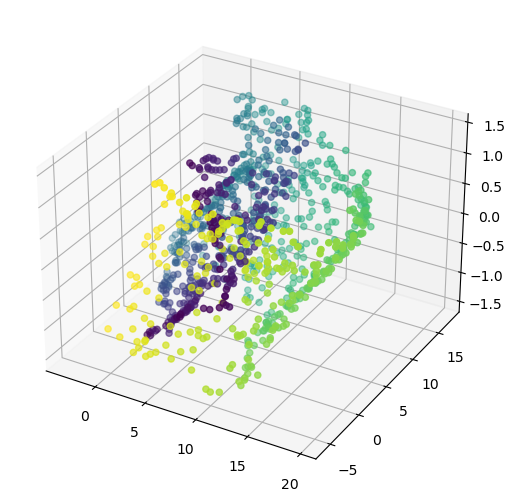

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],projection='3d')
ax.scatter3D(ms.pca_data[:,0],ms.pca_data[:,1],ms.pca_data[:,2],c=phi)

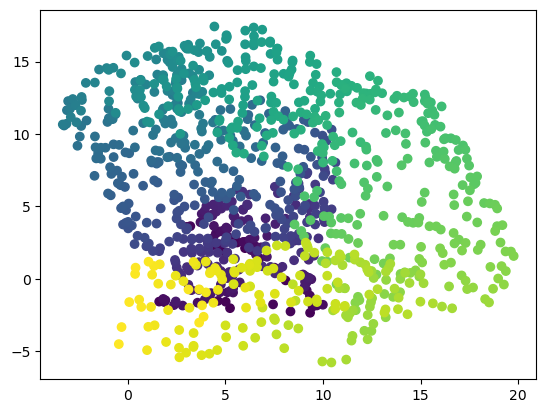

In [19]:
plt.scatter(ms.pca_data[:,0],ms.pca_data[:,1],c=phi)

In [23]:
tree = KDTree(roll)
k = 5
n = 1000
dist, ind = tree.query(roll,k+1)
dist = dist[:,1:]
ind = ind[:,1:]
aveNeighDist = np.mean(dist)

In [24]:
# it is very possible that this does some random stuff. check at some point
colinearNei = np.zeros((n,k))
theta = np.zeros((n,k))
for point,neighbourhood in enumerate(ind):
    for _it,neighbour in enumerate(neighbourhood): # _it is an iterator over the neigh of i
        da = data[point]-data[neighbour]
        la = da.dot(da)
        cosines = np.zeros(k)
        # _itt is an iterator over the neigh of neighbour
        for _itt,candidate in enumerate(ind[neighbour]): #possibly have problems if the neigh is pt i itself
            db = data[candidate] - data[neighbour]
            lb = db.dot(db)
            cosTheta = np.dot(da,db)/np.sqrt(la*lb)
            cosines[_itt] = cosTheta
        bestidx = np.argmin(cosines)
        colinearNei[point,_it] = ind[neighbour,bestidx]
        theta[point,_it] = cosines[bestidx]


In [25]:
for i,row in enumerate(colinearNei):
    for j in row:
        if i == j:
            print(f'pt {i} has itself as most colinear')
# this should check if any of the points has itself as most colinear point.
# it seems that this is not the case for any point, which is suspicious.

In [26]:
# perform PCA on the data
roll = roll-np.mean(roll,axis=0)
cov = np.cov(roll.T)
eigval, eigvec = np.linalg.eig(cov)
idx = np.argsort(-eigval)
eigvals = eigval[idx]
eigvec = eigvec[:,idx]
pRoll = roll@eigvec

In [31]:
@njit
def transform(data):
    pRoll = data

    target_dim = 2
    nnei = 5
    lr = aveNeighDist

    epoch = 0
    while epoch<800:
        pRoll[:,target_dim:] *= 0.9

        origin = np.random.choice(np.array(list(range(roll.shape[0]))))

        q = []
        q.append(origin)
        visited = []

        while q:
            point = q.pop(0)
            if point in visited:
                continue
            cPoint = pRoll[point].astype(np.float32)
            
            neighbourhood = ind[point]
            for p in neighbourhood:
                if not (p in visited):
                    q.append(p)
            cNeighbourhood = pRoll[neighbourhood,:].astype(np.float32)
            colinear = colinearNei[point]
            cColinear = pRoll[colinear.astype(np.int32),:].astype(np.float32)
            
            _d = np.array([np.dot((cPoint-neigh),(cPoint-neigh)) for neigh in cNeighbourhood])
            _cosTheta = np.zeros(nnei)
            for it in range(nnei):
                neigh = cNeighbourhood[it]
                col = cColinear[it]
                _cosTheta[it] = np.dot((cPoint-neigh),(col-neigh))/np.sqrt(np.linalg.norm(cPoint-neigh)*np.linalg.norm(neigh-col))
            # _cosTheta = np.array([np.dot((cPoint-neigh),(col-neigh))/np.sqrt(np.linalg.norm(cPoint-neigh)*np.linalg.norm(neigh-col)) for neigh,col in np.column_stack((cNeighbourhood,cColinear))])

            err = np.sum((_d-dist[point])**2 + (_cosTheta-theta[point])**2)

            if err<1e-6:
                visited.append(point)
                continue

            step_size = lr * np.random.uniform(0.4,1)
            step = 0
            improved = True
            while (step < 30) and (improved):
                improved = False
                for dim in range(target_dim):
                    cPoint[dim] += step_size

                    _d = np.array([np.dot((cPoint-neigh),(cPoint-neigh)) for neigh in cNeighbourhood])
                    _cosTheta = np.zeros(nnei)
                    for it in range(nnei):
                        neigh = cNeighbourhood[it]
                        col = cColinear[it]
                        _cosTheta[it] = np.dot((cPoint-neigh),(col-neigh))/np.sqrt(np.linalg.norm(cPoint-neigh)*np.linalg.norm(neigh-col))
                    # _cosTheta = np.array([np.dot((cPoint-neigh),(col-neigh))/np.sqrt(np.linalg.norm(cPoint-neigh)*np.linalg.norm(neigh-col)) for neigh,col in np.column_stack((cNeighbourhood,cColinear))])

                    newErr = np.sum((_d-dist[point])**2 + (_cosTheta-theta[point])**2)

                    if newErr > err:
                        cPoint[dim] -= 2*step_size

                        _d = np.array([np.dot((cPoint-neigh),(cPoint-neigh)) for neigh in cNeighbourhood])
                        _cosTheta = np.zeros(nnei)
                        for it in range(nnei):
                            neigh = cNeighbourhood[it]
                            col = cColinear[it]
                            _cosTheta[it] = np.dot((cPoint-neigh),(col-neigh))/np.sqrt(np.linalg.norm(cPoint-neigh)*np.linalg.norm(neigh-col))
                        # _cosTheta = np.array([np.dot((cPoint-neigh),(col-neigh))/np.sqrt(np.linalg.norm(cPoint-neigh)*np.linalg.norm(neigh-col)) for neigh,col in np.column_stack((cNeighbourhood,cColinear))])
                        newErr = np.sum((_d-dist[point])**2 + (_cosTheta-theta[point])**2)

                        pRoll[point] = np.copy(cPoint)
                    if newErr > err:
                        cPoint[dim] += step_size
                        pRoll[point] = np.copy(cPoint)
                    else:
                        err = newErr
                        improved = True
                step += 1

            visited.append(point)

            # print(f'visited pt {point}, |q|={len(q)}, |visited|={len(visited)}')
        
        if epoch%20==0:
            mean = np.zeros(pRoll.shape[1])
            for it in range(pRoll.shape[1]):
                mean[it] = np.mean(pRoll[:,it])
            pRoll = pRoll- mean

        epoch += 1
    return pRoll

In [32]:
pRoll = transform(pRoll)

In [29]:
pRoll[:,2]

array([-1.60903076e-37, -3.56819265e-37, -1.34186637e-36, -4.89086795e-37,
       -1.21401369e-36, -1.11501413e-36, -1.18956043e-36, -4.16620652e-37,
       -1.28616841e-36, -7.99757916e-38,  6.50999725e-37,  7.09235403e-37,
        5.46562094e-37, -1.43627595e-36,  1.46164208e-37,  9.20747034e-38,
        1.08731187e-37, -1.39880707e-36, -5.82579904e-37, -5.82137946e-37,
       -3.83689062e-37,  1.41287126e-36, -9.12204943e-37, -1.12554938e-36,
       -2.96783715e-37, -5.29439371e-38, -5.85254658e-37, -1.00942116e-36,
       -1.13721769e-36,  4.40722582e-37,  6.83067981e-37, -5.79889142e-37,
        7.71817796e-37, -7.43856936e-37,  1.12933796e-36, -1.29530739e-36,
        9.31514253e-37,  1.32948051e-36, -5.91641843e-37,  1.18826756e-36,
       -6.27389797e-37,  4.15383967e-37, -3.96576523e-37,  6.43007930e-37,
        4.63191248e-37, -1.03065794e-36, -1.05870381e-36, -8.91345943e-38,
        5.47340319e-37,  8.64671464e-37, -8.51548764e-37, -1.29577132e-36,
        5.28202125e-37,  

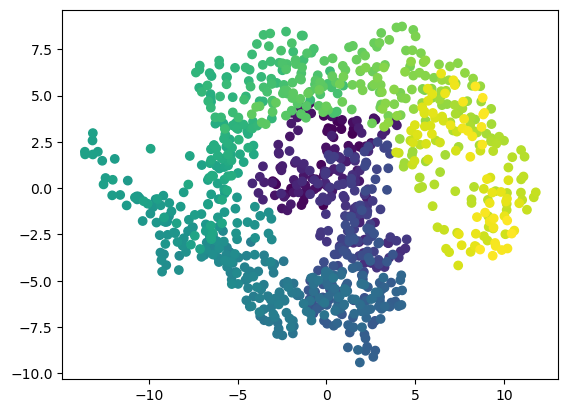

In [33]:
plt.scatter(pRoll[:,0],pRoll[:,1],c = phi)

In [34]:
a = np.ones((5,5))
idx = [1,2,3]
a[:,idx] *= 0.5

In [35]:
a

array([[1. , 0.5, 0.5, 0.5, 1. ],
       [1. , 0.5, 0.5, 0.5, 1. ],
       [1. , 0.5, 0.5, 0.5, 1. ],
       [1. , 0.5, 0.5, 0.5, 1. ],
       [1. , 0.5, 0.5, 0.5, 1. ]])